<a href="https://colab.research.google.com/github/Oscar19922017/Ml/blob/master/ModeloClasificadorTexto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1 Clasificación de texto práctica con Python y Keras**

Imagina que pudieras conocer el estado de ánimo de la gente en Internet. Tal vez no esté interesado en su totalidad, pero solo si la gente está feliz hoy en su plataforma de redes sociales favorita. Después de este tutorial, estará equipado para hacer esto. Al hacer esto, comprenderá los avances actuales de las redes neuronales (profundas) y cómo se pueden aplicar al texto.

Leer el estado de ánimo del texto con aprendizaje automático se denomina análisis de sentimientos y es uno de los casos de uso destacados en la clasificación de texto. Esto se enmarca en el campo de investigación muy activo del procesamiento del lenguaje natural (PNL) . Otros casos de uso común de la clasificación de texto incluyen la detección de spam, el etiquetado automático de las consultas de los clientes y la categorización del texto en temas definidos.

## **Elegir un conjunto de datos**
 
Antes de comenzar, echemos un vistazo a los datos que tenemos. Continúe y descargue el conjunto de datos del Conjunto de datos de frases con etiquetas de opinión del Repositorio de aprendizaje automático de UCI.

https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

Por cierto, este repositorio es una fuente maravillosa para conjuntos de datos de aprendizaje automático cuando desea probar algunos algoritmos. Este conjunto de datos incluye reseñas etiquetadas de IMDb, Amazon y Yelp. Cada reseña se marca con una puntuación de 0 para un sentimiento negativo o 1 para un sentimiento positivo.

Extraiga la carpeta en una datacarpeta y continúe y cargue los datos con Pandas

In [28]:
import pandas as pd

In [29]:
filepath_dict= {
    "yelp": '/content/drive/MyDrive/Diplomado_2022_01/Redes Neuronales/yelp_labelled.txt',
    "amazon":'/content/drive/MyDrive/Diplomado_2022_01/Redes Neuronales/amazon_cells_labelled.txt',
    "imdb": '/content/drive/MyDrive/Diplomado_2022_01/Redes Neuronales/imdb_labelled.txt'
}

In [30]:
df_list=[]

for source, filepath in filepath_dict.items():
  df=pd.read_csv(filepath,names=["sentence","label"],sep='\t')
  df["source"]=source
  df_list.append(df)

In [31]:
df=pd.concat(df_list)

In [32]:
print(df.iloc[12])

sentence    The cashier had no care what so ever on what I...
label                                                       0
source                                                   yelp
Name: 12, dtype: object


Esto parece correcto. Con este conjunto de datos, puede entrenar un modelo para predecir el sentimiento de una oración. Tómate un momento para pensar cómo harías para predecir los datos.

Una forma de hacerlo es contar la frecuencia de cada palabra en cada oración y vincular este recuento con el conjunto completo de palabras en el conjunto de datos. Comenzaría tomando los datos y creando un vocabulario a partir de todas las palabras en todas las oraciones. La colección de textos también se denomina corpus en PNL.

El vocabulario en este caso es una lista de palabras que ocurrieron en nuestro texto donde cada palabra tiene su propio índice. Esto le permite crear un vector para una oración. Luego tomaría la oración que desea vectorizar y contará cada ocurrencia en el vocabulario. El vector resultante será con la longitud del vocabulario y un recuento de cada palabra del vocabulario.

El vector resultante también se denomina vector de características . En un vector de características, cada dimensión puede ser una característica numérica o categórica, como por ejemplo la altura de un edificio, el precio de una acción o, en nuestro caso, el recuento de una palabra en un vocabulario. Estos vectores de características son una pieza crucial en la ciencia de datos y el aprendizaje automático, ya que el modelo que desea entrenar depende de ellos.

Ilustremos esto rápidamente. Imagina que tienes las siguientes dos oraciones:

In [33]:
sentences = ['John likes ice cream', 'John hates chocolate.']

A continuación, puede utilizar lo CountVectorizerproporcionado por la biblioteca scikit-learn para vectorizar oraciones. Toma las palabras de cada oración y crea un vocabulario de todas las palabras únicas en las oraciones. Este vocabulario se puede utilizar para crear un vector de características del recuento de palabras:]

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'chocolate': 1, 'cream': 2, 'hates': 3, 'ice': 4, 'likes': 5}

Este vocabulario también sirve como índice de cada palabra. Ahora, puede tomar cada oración y obtener las apariciones de palabras de las palabras basándose en el vocabulario anterior. El vocabulario consta de las cinco palabras de nuestras oraciones, cada una de las cuales representa una palabra del vocabulario. Cuando tomas las dos oraciones anteriores y las transformas con el CountVectorizer, obtendrás un vector que representa el recuento de cada palabra de la oración:

In [35]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

Ahora, puede ver los vectores de características resultantes para cada oración según el vocabulario anterior. Por ejemplo, si observa el primer elemento, puede ver que ambos vectores tienen un 1allí. Esto significa que ambas oraciones tienen una aparición de John, que está en primer lugar en el vocabulario.

Esto se considera un modelo de bolsa de palabras (BOW) , que es una forma común en PNL de crear vectores a partir de texto. Cada documento se representa como un vector. Puede usar estos vectores ahora como vectores de características para un modelo de aprendizaje automático. Esto nos lleva a la siguiente parte, definir un modelo de línea base.

## **Definición de un modelo de línea base**

Cuando trabaja con el aprendizaje automático, un paso importante es definir un modelo de referencia. Esto generalmente implica un modelo simple, que luego se usa como una comparación con los modelos más avanzados que desea probar. En este caso, usará el modelo de línea de base para compararlo con los métodos más avanzados que involucran redes neuronales (profundas)

Primero, dividirá los datos en un conjunto de entrenamiento y prueba que le permitirá evaluar la precisión y ver si su modelo se generaliza bien. Esto significa si el modelo puede funcionar bien con datos que no ha visto antes. Esta es una forma de ver si el modelo está sobreajustado.

El sobreajuste es cuando un modelo se entrena demasiado bien con los datos de entrenamiento. Desea evitar el sobreajuste, ya que esto significaría que el modelo en su mayoría simplemente memorizó los datos de entrenamiento. Esto explicaría una gran precisión con los datos de entrenamiento, pero una baja precisión en los datos de prueba.

Comenzamos tomando el conjunto de datos de Yelp que extraemos de nuestro conjunto de datos concatenados. A partir de ahí, tomamos las oraciones y las etiquetas. El .valuesdevuelve una matriz NumPy en lugar de una serie pandas objeto que es en este contexto más fácil trabajar con:

In [36]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [37]:
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences,
                                                                    y,
                                                                    test_size=0.25,
                                                                    random_state=1000)

Aquí usaremos nuevamente en el modelo BOW anterior para vectorizar las oraciones. Puede volver a utilizar el CountVectorizerpara esta tarea. Dado que es posible que no tenga los datos de prueba disponibles durante el entrenamiento, puede crear el vocabulario utilizando solo los datos de entrenamiento. Con este vocabulario, puede crear los vectores de características para cada oración del conjunto de entrenamiento y prueba:

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

CountVectorizer()

In [39]:
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)


In [40]:
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

In [41]:
# Python program to generate WordCloud 
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

comment_words = ''
stopwords = set(STOPWORDS)

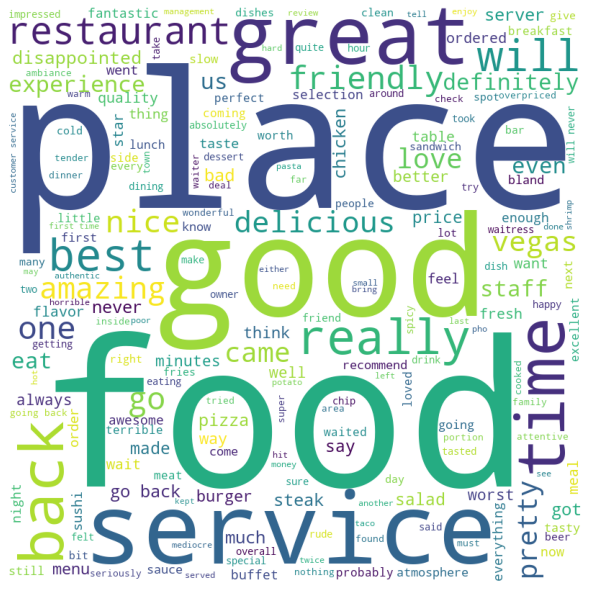

In [42]:
for val in df_yelp['sentence']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

**Ajustamos el Modelo Regresión Logistica**

In [43]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

In [44]:

print("Accuracy:", score)

Accuracy: 0.796


Puede ver que la regresión logística alcanzó un impresionante 79,6%, pero echemos un vistazo al rendimiento de este modelo en los otros conjuntos de datos que tenemos. En este script, realizamos y evaluamos todo el proceso para cada conjunto de datos que tenemos:

In [45]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


Puede ver que este modelo bastante simple logra una precisión bastante buena. Sería interesante ver si podemos superar a este modelo. En la siguiente parte, nos familiarizaremos con las redes neuronales (profundas) y cómo aplicarlas a la clasificación de texto.

## **Red Neuronal**

In [46]:
from keras.models import Sequential
from keras import layers

In [47]:
input_dim = X_train.shape[1]  # Number of features
input_dim

2505

In [56]:
model = Sequential()
# Primera capa
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
## Capas ocultas
#model.add(layers.Dense(15, activation='relu'))
#model.add(layers.Dense(10,  activation='relu'))
model.add(layers.Dense(5, activation='relu'))
#model.add(layers.Dense(3, activation='relu'))
# Capa salidad
model.add(layers.Dense(1, activation='sigmoid'))

In [57]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                25060     
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 25,121
Trainable params: 25,121
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model.fit(X_train, y_train,
                     epochs=100,
                     verbose=False,
                     validation_data=(X_test, y_test),
                     batch_size=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


In [59]:
from keras.backend import clear_session
clear_session()

In [60]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7807


In [61]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="Training acc")
    plt.plot(x, val_acc, "r", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="Training loss")
    plt.plot(x, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

In [62]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


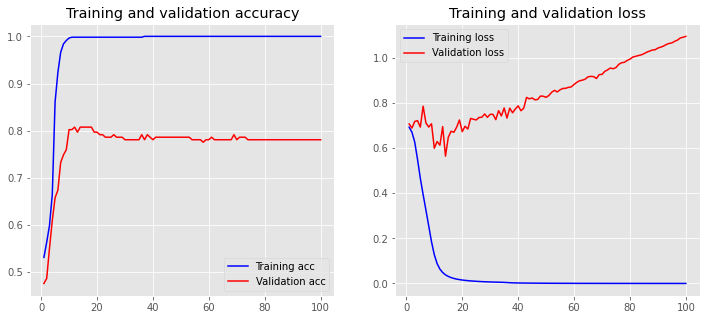

In [63]:
plot_history(history)